/tmp/ipykernel_956984/1476738577.py:7: RuntimeWarning: overflow encountered in exp
  numerator = np.sum(np.exp(scaling_factor * energies))
/tmp/ipykernel_956984/1476738577.py:8: RuntimeWarning: overflow encountered in scalar power
  denominator = np.sum(np.exp(energies))**scaling_factor
/tmp/ipykernel_956984/1476738577.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return np.log(numerator / denominator)
/tmp/ipykernel_956984/1476738577.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)
/home/ubuntu/nethome-blazejb/minimol/.minimol_p3-12/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


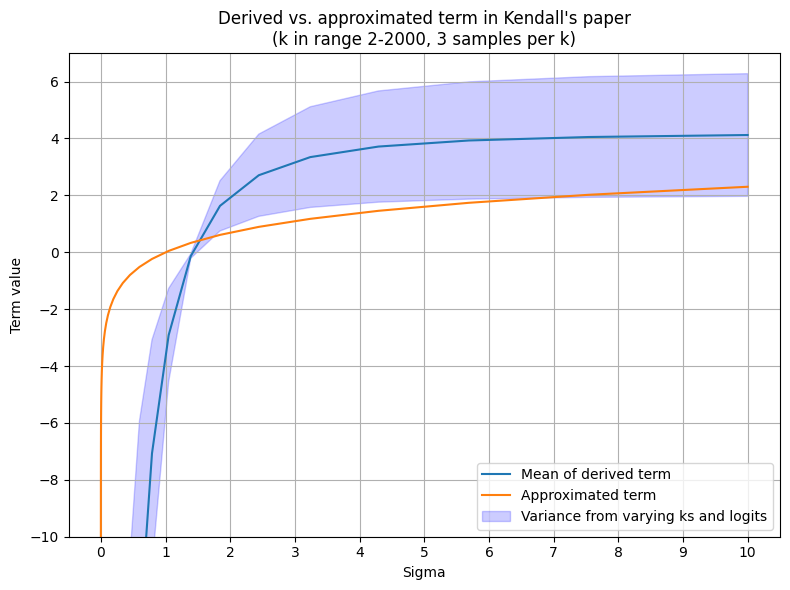

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

def reg_term(energies, sigma):
    scaling_factor = 2 / sigma**2
    numerator = np.sum(np.exp(scaling_factor * energies))
    denominator = np.sum(np.exp(energies))**scaling_factor
    return np.log(numerator / denominator)

sigmas = np.logspace(-5, 1, 50)
ks = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
num_samples_per_k = 3
derived_curves = []

for k in ks:
    for _ in range(num_samples_per_k):
        logits = np.random.randn(k)
        derived_terms = [reg_term(logits, sigma) for sigma in sigmas]
        derived_curves.append(derived_terms)

derived_curves = np.array(derived_curves)

mean_derived = np.mean(derived_curves, axis=0)
var_derived = np.var(derived_curves, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(sigmas, mean_derived, label='Mean of derived term')

approximated_terms = np.log(sigmas)
plt.plot(sigmas, approximated_terms, label='Approximated term')

plt.fill_between(
    sigmas, mean_derived - np.sqrt(var_derived), mean_derived + np.sqrt(var_derived),
    color='blue', alpha=0.2, label='Variance from varying ks and logits')

plt.ylim(-10, 7)
plt.xlabel('Sigma')
plt.xticks(np.arange(max(sigmas) + 1))
plt.ylabel('Term value')
plt.title('Derived vs. approximated term in Kendall\'s paper\n(k in range 2-2000, 3 samples per k)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_980287/3135842539.py:10: RuntimeWarning: invalid value encountered in log
  loss_values_sigma = np.log(kendalls_loss_sigma(L_grid_sigma, sigma_grid))
/tmp/ipykernel_980287/3135842539.py:18: RuntimeWarning: invalid value encountered in log
  loss_values_weight = np.log(kendalls_loss_weight(L_grid_weight, weight_grid))


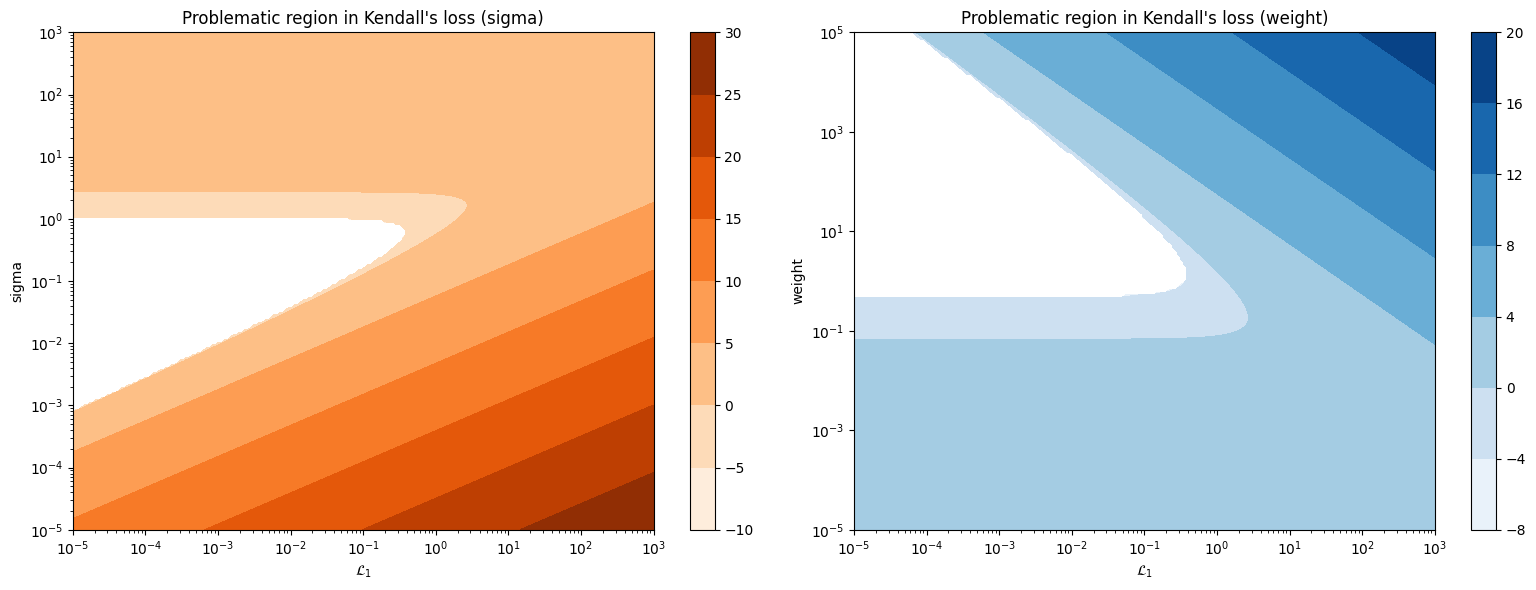

In [2]:
import numpy as np
import matplotlib.pyplot as plt

L = np.logspace(-5, 3, 200)

# figure with sigma
sigma = np.logspace(-5, 3, 200)
L_grid_sigma, sigma_grid = np.meshgrid(L, sigma)
kendalls_loss_sigma = lambda loss, std: (1 / (2 * (std**2))) * loss + np.log(std)
loss_values_sigma = np.log(kendalls_loss_sigma(L_grid_sigma, sigma_grid))

# figure with weight
# weight = 1 / (2 * sigma^2)
# So, sigma = sqrt(1 / (2 * weight))
weight = np.logspace(-5, 5, 200)
L_grid_weight, weight_grid = np.meshgrid(L, weight)
kendalls_loss_weight = lambda loss, weight: weight * loss - 0.5 * np.log(2 * weight)
loss_values_weight = np.log(kendalls_loss_weight(L_grid_weight, weight_grid))

# Plt stuff
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
cp1 = plt.contourf(L_grid_sigma, sigma_grid, loss_values_sigma, cmap='Oranges')
plt.colorbar(cp1)
plt.title("Problematic region in Kendall's loss (sigma)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\mathcal{L}_1$')
plt.ylabel('sigma')

plt.subplot(1, 2, 2)
cp2 = plt.contourf(L_grid_weight, weight_grid, loss_values_weight, cmap='Blues')
plt.colorbar(cp2)
plt.title("Problematic region in Kendall's loss (weight)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\mathcal{L}_1$')
plt.ylabel('weight')

plt.tight_layout()
plt.show()


/tmp/ipykernel_1143732/2875190808.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


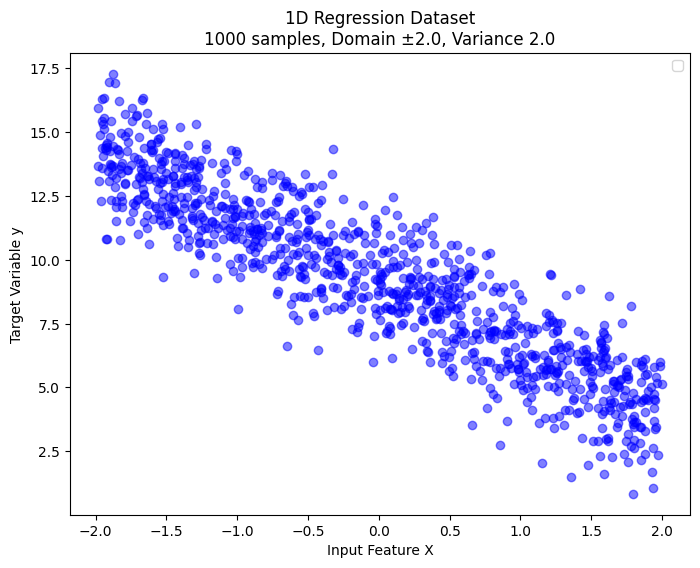

In [2]:
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

def generate_1d_regression_dataset(n_samples=1000, domain_range=2.0, variance=0.1, seed=42, as_tensors=False):
    np.random.seed(seed)
    a = np.random.uniform(-10, 10)
    b = np.random.uniform(-10, 10)
    f = lambda x: (a * x) + b
    x = np.random.uniform(-domain_range, domain_range, n_samples).reshape(-1, 1)
    y = f(x).flatten() + np.random.normal(0, np.sqrt(variance), n_samples)
    if as_tensors:
        x_tensor = torch.from_numpy(x).float()
        y_tensor = torch.from_numpy(y).float().view(-1, 1)
        return x_tensor, y_tensor
    return x, y

x, y = generate_1d_regression_dataset(n_samples=1000, domain_range=2.0, variance=2.0)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c='blue', alpha=0.5)
plt.title(f'1D Regression Dataset\n{1000} samples, Domain ±{2.0}, Variance {2.0}')
plt.xlabel('Input Feature X')
plt.ylabel('Target Variable y')
plt.legend()
plt.show()

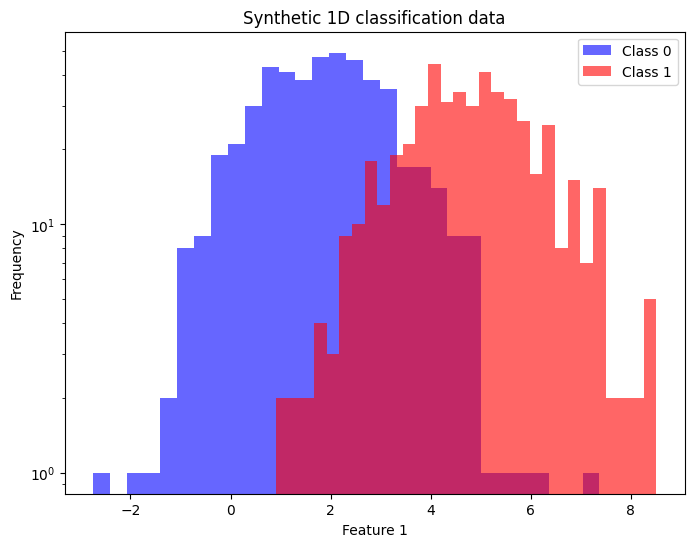

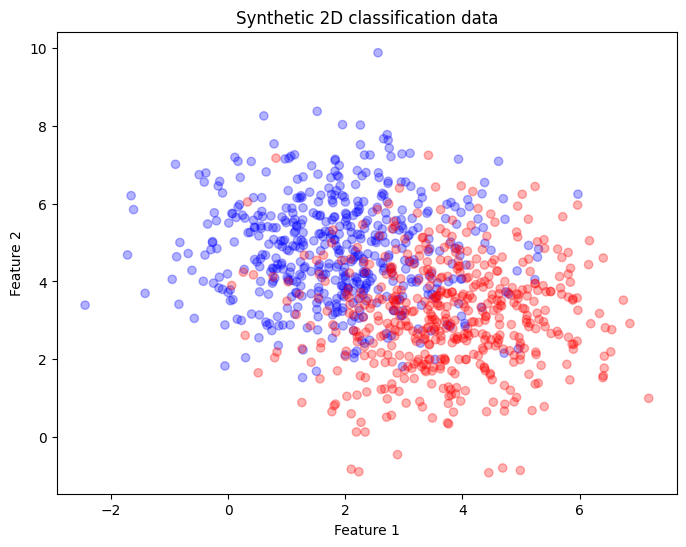

In [111]:
import numpy as np
import matplotlib.pyplot as plt

def generate_classification_data(n_samples      : int,
                                 variance       : float, 
                                 n_features     : int = 2, 
                                 mean_range     : tuple = (0, 5), 
                                 variance_range : tuple = (0.5, 2.5), 
                                 seed           : int = 42, 
                                 as_tensors     : bool = False,
                                 one_hot        : bool = False):
    """
    The variance is defined as `(var0 + var1) / (||mu1 - mu0||^2)`
    """
    np.random.seed(seed)

    # var0, var1 = 0, -1
    # while var1 <= 0:
    #     mu0 = np.random.uniform(mean_range[0], mean_range[1], n_features)
    #     mu1 = np.random.uniform(mean_range[0], mean_range[1], n_features)
    #     mean_distance = np.linalg.norm(mu1 - mu0) ** 2
    #     var0 = np.random.uniform(variance_range[0], variance_range[1])
    #     var1 = variance * mean_distance - var0
    

    mu0 = np.random.uniform(mean_range[0], mean_range[1], n_features)
    mu1 = np.random.uniform(mean_range[0], mean_range[1], n_features)
    mean_distance = np.linalg.norm(mu1 - mu0) ** 2
    var0 = var1 = variance * mean_distance / 2

    cov0 = np.diag([np.sqrt(var0)] * n_features)
    cov1 = np.diag([np.sqrt(var1)] * n_features)
    
    X0 = np.random.multivariate_normal(mu0, cov0, n_samples//2)
    X1 = np.random.multivariate_normal(mu1, cov1, n_samples//2)
    
    x = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n_samples//2), np.ones(n_samples//2)])
    
    if one_hot:
        y = np.eye(2)[y.astype(int)]

    if as_tensors:
        x_tensor = torch.from_numpy(x).float()
        y_tensor = torch.from_numpy(y).float() if one_hot else torch.from_numpy(y).long()
        return x_tensor, y_tensor
    
    return x, y

n_samples = 1000
class_variance = 1.0

x, y = generate_classification_data(n_samples, class_variance, n_features=1)
plt.figure(figsize=(8, 6))
plt.hist(x[y == 0, 0], log=True, bins=30, alpha=0.6, color='blue', label='Class 0')
plt.hist(x[y == 1, 0], log=True, bins=30, alpha=0.6, color='red', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Frequency')
plt.title('Synthetic 1D classification data')
plt.legend()
plt.show()

x, y = generate_classification_data(n_samples, class_variance, n_features=2)
plt.figure(figsize=(8, 6))
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', alpha=0.3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Synthetic 2D classification data')
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


class LinearRegressionModel(nn.Module):
    def __init__(self, uw: bool = False, prior: callable = None):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)
        self.log_variance = nn.Parameter(torch.tensor(2.0), requires_grad=True) if uw else None
        self.criterion = nn.MSELoss(reduction='mean')
        self.prior = prior

    def forward(self, x):
        return self.linear(x)
        
    def _get_log_sqrt_var(self):
        return 0.5 * self.log_variance if self.log_variance else None
        
    def _get_loss_weight(self):
        return 0.5 * torch.exp(-self.log_variance) if self.log_variance else None

    def compute_loss(self, y, y_true):
        if self.log_variance:
            loss = self._get_loss_weight() * self.criterion(y, y_true) + self._get_log_sqrt_var()
            loss += self.prior(self.log_variance) if self.prior else 0.0
            return loss
        
        return self.criterion(y, y_true)


class LogisticRegressionModel(nn.Module):
    def __init__(self, uw: bool = False, n_features: int = 1, prior: callable = None):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(n_features, 2)
        self.log_variance = nn.Parameter(torch.tensor(2.0), requires_grad=True) if uw else None
        self.criterion = nn.BCEWithLogitsLoss(reduction='mean')

    def forward(self, x):
        return self._get_loss_weight() * self.linear(x)
    
    def _exact_reg_term(self, logits):
        numerator = torch.sum(torch.exp(self._get_loss_weight() * logits))
        denominator = torch.sum(torch.exp(logits))**(self._get_loss_weight())
        return torch.log(numerator / denominator)

    def _get_log_sigma(self):
        return 0.5 * self.log_variance if self.log_variance else None
        
    def _get_loss_weight(self):
        return torch.exp(-self.log_variance) if self.log_variance else None

    def compute_loss(self, y, y_true):
        if self.log_variance:
            return  self._get_loss_weight() * self.criterion(y, y_true) + self._get_log_sigma()
        
        return self.criterion(y, y_true)


In [4]:
from typing import Union


def run(variance             : float,
        data_generator       : callable              = generate_1d_regression_dataset,
        model_class          : classmethod           = LinearRegressionModel,
        epochs               : int                   = 10, 
        n_samples            : int                   = 1000,
        batch_size           : int                   = 128,
        lr                   : Union[float, tuple]   = 1e-1,
        prior                : callable              = None,
        uncertainty_weighing : bool                  = False,
        device               : str                   = 'cpu',
        repeats              : int                   = 1,
        verbose              : bool                  = False):

    log_variances = np.zeros(shape=(repeats))

    for i, seed in enumerate(range(repeats)):
        x, y = data_generator(n_samples=n_samples, variance=variance, seed=seed, as_tensors=True)
        model = model_class(uw=uncertainty_weighing, prior=prior).to(device)

        if isinstance(lr, tuple) or isinstance(lr, list):
            lr1 = lr[0]
            lr2 = lr[1]
        else:
            lr1 = lr2 = lr

        params = [
            {'params': model.linear.parameters(), 'lr': lr1},
            {'params': [model.log_variance],      'lr': lr2}
        ]

        optimizer = optim.Adam(params)
        dataloader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):

            for x_batch, y_true in dataloader:
                x_batch = x_batch.to(device)
                y_true = y_true.to(device)
                optimizer.zero_grad()
                outputs = model(x_batch)
                loss = model.compute_loss(outputs, y_true)
                loss.backward()
                optimizer.step()

        log_variances[i] = torch.exp(model.log_variance).detach().cpu().numpy()

    return log_variances

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error as mae

repeats = 3
true_vars = np.logspace(-2.0, 0.5, 12)
learned_vars = np.zeros_like(true_vars)

for j, variance in enumerate(true_vars):

    sample_vars = run(
        variance=variance,
        data_generator=generate_1d_regression_dataset,
        model_class=LinearRegressionModel,
        epochs=1,
        batch_size=256,
        n_samples=2000*256,
        lr=(1e-1, 1.15e-1),
        # prior=lambda x: x/3
        repeats=repeats,
        device=torch.device('cuda'),
        uncertainty_weighing=True,
    )

    learned_vars[j] = np.mean(sample_vars)

print(f'MAE = {mae(np.log(true_vars), np.log(learned_vars))}')
plt.figure(figsize=(8, 6))
plt.plot(true_vars, learned_vars, color='blue', alpha=0.7, label=f'estimated variance')
plt.plot(true_vars, true_vars, c='gray', alpha=0.3, label='ideal')
# plt.xscale('log')
# plt.yscale('log')
plt.show()

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import scipy.stats as stats

plt.figure(figsize=(8, 6))

repeats = 3
lrs = np.logspace(-2.0, 0.4, 12)
true_vars = np.logspace(-2.0, 0.5, 12)
gofs = np.zeros((len(lrs), len(lrs)))
colors = plt.cm.magma(np.linspace(0.1, 1, len(lrs)))
device = torch.device('cpu')

for i, lr_weights in enumerate(lrs):
    print(f'{i + 1} / {len(lrs)}')
    for k, lr_uw in enumerate(lrs):
        
        learned_vars = np.zeros_like(true_vars)
        
        for j, variance in enumerate(true_vars):

            sample_vars = run(
                variance,
                data_generator=generate_1d_regression_dataset,
                model_class=LinearRegressionModel,
                epochs=1,
                batch_size=4,
                n_samples=3000,
                device=device,
                repeats=repeats,
                lr=(lr_weights, lr_uw),
                uncertainty_weighing=True
            )

            learned_vars[j] = np.mean(sample_vars)
        
        gofs[i][k] = mae(np.log(true_vars), np.log(learned_vars))

gofs_transformed = np.cbrt(np.clip(gofs, 0, 5))

plt.figure(figsize=(10, 8))
plt.imshow(gofs_transformed, aspect='auto', cmap='magma', origin='lower', extent=[lrs.min(), lrs.max(), lrs.min(), lrs.max()])
cbar = plt.colorbar(label='Transformed Mean Absolute Error (cube root)')
cbar.set_ticks([np.min(gofs_transformed), np.cbrt(1), np.cbrt(5)])
cbar.set_ticklabels(['0', '1', '5'])
plt.xlabel('Learning Rate for Uncertainty Weight')
plt.ylabel('Learning Rate for Model Parameters')
# plt.xscale('log')
# plt.yscale('log')
plt.title('Goodness of Fit (MAE) for Varying Learning Rates')
plt.show()

1 / 12


KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>

1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


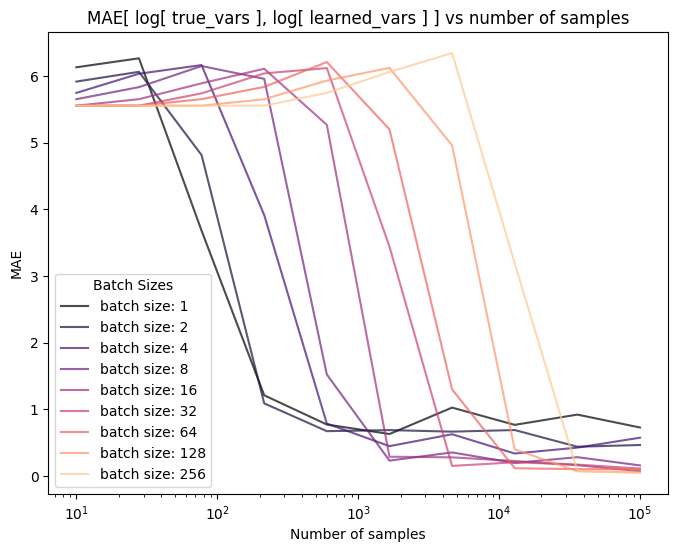

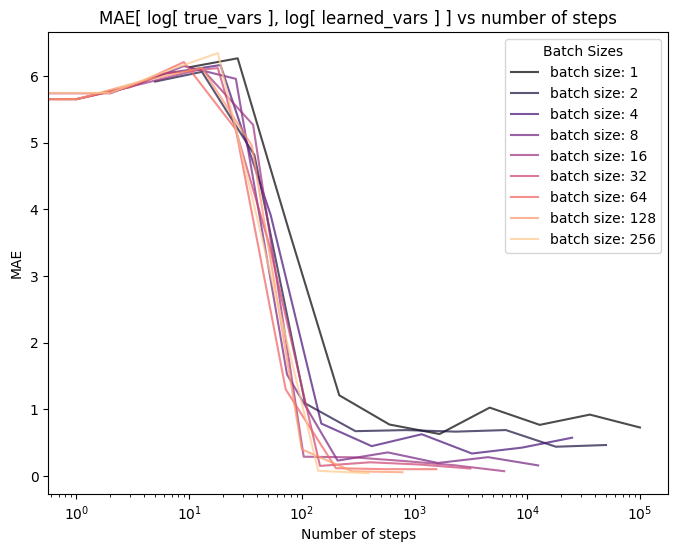

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import torch

repeats = 1
true_vars = np.logspace(-3, 0, 10)
num_samples = np.logspace(1, 5, 10)

batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256]

gofs = np.zeros(shape=[len(batch_sizes), len(num_samples)])

for k, batch_size in enumerate(batch_sizes):
    print(f"{k + 1} / {len(batch_sizes)}")
    device = torch.device('cpu' if batch_size < 64 else 'cuda')
    
    for i, samples in enumerate(num_samples):

        learned_vars = np.zeros_like(true_vars)

        for j, variance in enumerate(true_vars):

            sample_vars = run(
                variance,
                epochs=1,
                device=device,
                lr=(1e-1, 1e-1),
                repeats=repeats,
                n_samples=int(samples),
                batch_size=batch_size,
                # prior=lambda x: x/3
                uncertainty_weighing=True,
            )

            learned_vars[j] = np.mean(sample_vars)
        
        gofs[k][i] = mae(np.log(true_vars), np.log(learned_vars))

plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("magma")
colors = [cmap(i / len(batch_sizes)) for i in range(len(batch_sizes))]
for k, batch_size in enumerate(batch_sizes):
    plt.plot(num_samples, gofs[k], color=colors[k], alpha=0.7, label=f'batch size: {batch_size}')

plt.legend(title='Batch Sizes')
plt.title('MAE[ log[ true_vars ], log[ learned_vars ] ] vs number of samples')
plt.xlabel('Number of samples')
plt.ylabel('MAE')
plt.xscale('log')
plt.show()

plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("magma")
colors = [cmap(i / len(batch_sizes)) for i in range(len(batch_sizes))]
for k, batch_size in enumerate(batch_sizes):
    num_steps = num_samples // batch_size
    plt.plot(num_steps, gofs[k], color=colors[k], alpha=0.7, label=f'batch size: {batch_size}')

plt.legend(title='Batch Sizes')
plt.title('MAE[ log[ true_vars ], log[ learned_vars ] ] vs number of steps')
plt.xlabel('Number of steps')
plt.ylabel('MAE')
plt.xscale('log')
plt.show()

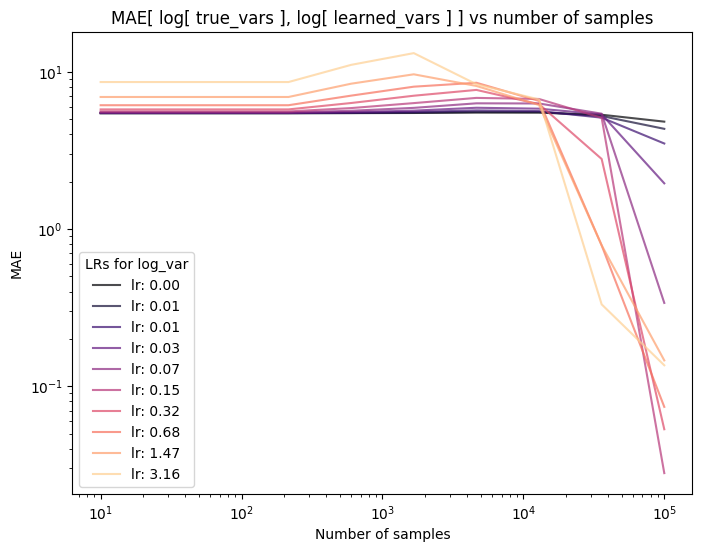

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import torch

repeats = 3
true_vars   = np.logspace(-3, 0, 10)
num_samples = np.logspace(1, 5, 10)
uw_lrs      = np.logspace(-2.5, 0.5, 10)

gofs = np.zeros(shape=[len(uw_lrs), len(num_samples)])

for k, uw_lr in enumerate(uw_lrs):
    print(f"{k + 1} / {len(uw_lrs)}")
    device = torch.device('cuda')
    
    for i, samples in enumerate(num_samples):

        learned_vars = np.zeros_like(true_vars)

        for j, variance in enumerate(true_vars):

            sample_vars = run(
                variance,
                epochs=1,
                device=device,
                lr=(1e-1, uw_lr),
                repeats=repeats,
                n_samples=int(samples),
                batch_size=256,
                # prior=lambda x: x/3
                uncertainty_weighing=True,
            )

            learned_vars[j] = np.mean(sample_vars)
        
        gofs[k][i] = mae(np.log(true_vars), np.log(learned_vars))

plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("magma")
colors = [cmap(i / len(uw_lrs)) for i in range(len(uw_lrs))]
for k, uw_lr in enumerate(uw_lrs):
    plt.plot(num_samples, gofs[k], color=colors[k], alpha=0.7, label=f'lr: {uw_lr:.2f}')

plt.legend(title='LRs for log_var')
plt.title('MAE[ log[ true_vars ], log[ learned_vars ] ] vs number of samples')
plt.xlabel('Number of samples')
plt.ylabel('MAE')
plt.xscale('log')
plt.yscale('log')
plt.show()

1 / 12
2 / 12
3 / 12
4 / 12
5 / 12
6 / 12
7 / 12
8 / 12
9 / 12
10 / 12
11 / 12
12 / 12
MAE = 1.2155274691550668


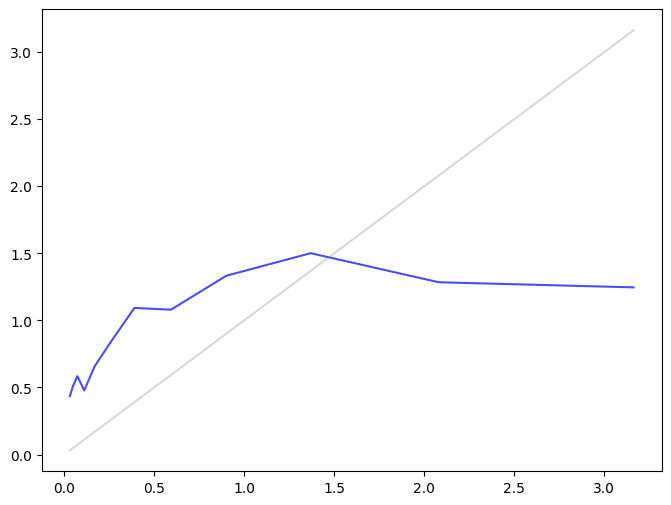

In [139]:
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from functools import partial

repeats = 2
n_features = 1
true_vars = np.logspace(-1.5, 0.5, 12)
learned_vars = np.zeros_like(true_vars)

for j, variance in enumerate(true_vars):
    print(f"{j + 1} / {len(true_vars)}")
    sample_vars = run(
        variance,
        data_generator=partial(generate_classification_data, n_features=n_features, one_hot=True),
        model_class=partial(LogisticRegressionModel, n_features=n_features),
        epochs=1,
        batch_size=2,
        n_samples=10000,
        lr=(1e-1, 1e-1),
        # prior=lambda x: x/3
        repeats=repeats,
        device=torch.device('cpu'),
        uncertainty_weighing=True,
    )

    learned_vars[j] = np.mean(sample_vars)

print(f'MAE = {mae(np.log(true_vars), np.log(learned_vars))}')
plt.figure(figsize=(8, 6))
plt.plot(true_vars, learned_vars, color='blue', alpha=0.7, label=f'estimated variance')
plt.plot(true_vars, true_vars, c='gray', alpha=0.3, label='ideal')
# plt.xscale('log')
# plt.yscale('log')
plt.show()